# Hilbert-Schmidt Independence Criterion (HSIC)

In [1]:
import sys
sys.path.append("../../../")

import objax
import jax
import jax.numpy as np

from jaxkern.kernels.stationary import RBF
from jaxkern.kernels.linear import Linear
from jaxkern.similarity import HSIC, CKA, HSICRBF, CKARBF
from jaxkern.sigma import estimate_sigma_median

# 
import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

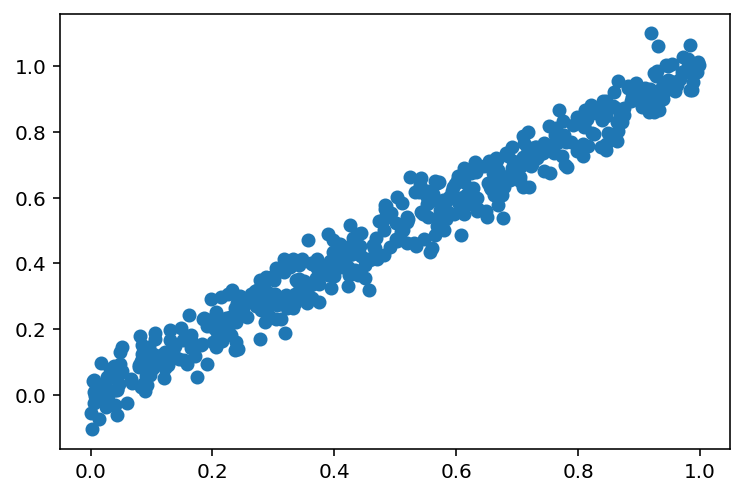

In [36]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500

X = rng.rand(n_samples)
Y = X + 0.05 * rng.randn(n_samples)

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

In [37]:
from jaxkern.kernels.utils import centering
K_x = Linear()(X, X)
K_y = Linear()(Y, Y)

K_x = centering(K_x)
K_y = centering(K_y)

hsic = np.sum(K_x * K_y) / np.linalg.norm(K_x) / np.linalg.norm(K_y)

print(hsic)

0.96995175


In [38]:
kernel = Linear()

hsic_clf = HSIC(kernel, kernel, bias=True)

hsic_val = hsic_clf(X, Y)


print(f"HSIC: {hsic_val:.4f}")
# calculate hsic value

HSIC: 0.0068


In [39]:
%timeit hsic_clf(X, Y)

29.4 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
hsic_clf = HSIC(kernel, kernel, bias=True)

hsic_clf_jit = objax.Jit(hsic_clf)

hsic_val = hsic_clf_jit(X, Y)

print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.0068


In [41]:
%timeit hsic_clf_jit(X, Y)

8.51 ms ± 842 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### RBF Kernel

In [47]:
sigma_f = estimate_sigma_median

nhsic_clf = HSICRBF(sigma_f, sigma_f)

nhsic_value = nhsic_clf(X, Y)

print(f"HSIC: {nhsic_value:.4f}")

HSIC: 0.0824


In [48]:
%timeit nhsic_clf(X, Y)

197 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
sigma_f = estimate_sigma_median

nhsic_clf = HSICRBF(sigma_f, sigma_f)

nhsic_clf = objax.Jit(nhsic_clf)

nhsic_value = nhsic_clf(X, Y)

print(f"nHSIC: {nhsic_value:.4f}")

nHSIC: 0.0824


In [ ]:
%timeit nhsic_clf(X, Y)